In [36]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw,AllChem,rdqueries
import pandas as pd
import collections,gzip,pickle,re,random,time
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdDepictor
rdDepictor.SetPreferCoordGen(True)
IPythonConsole.drawOptions.drawMolsSameScale=False

In [7]:
chembl=pd.read_csv("guacamol_v1_train.smiles",header=None)


# the idea of this generator:

essentially, it should fragment chembl and recombine the fragments. Then, for further diversity it should apply some sensible mutations (homologations, bioisosteres, etc?)

1. fragment at every bond that includes a ring atom that is not in a ring using smarts
2. the resulting fragments get ranked by occurence and the highest N for degree X (equal to amount of cut bonds in frag) get retained
3. a "reduced graph"(find the correct term for this) is produced and the top M reduced graphs get retained for generative template purposes.

In [8]:
mol=Chem.MolFromSmiles("CCCc1ccccc1")
fragment_smarts=Chem.MolFromSmarts("[*]-!@[R]")
q=rdqueries.AtomNumEqualsQueryAtom(0)


def fragment_mol(mol):
    mol=Chem.RWMol(mol)
    sm=mol.GetSubstructMatches(fragment_smarts)
    if len(sm)!=0:
        bidx=[mol.GetBondBetweenAtoms(a[0],a[1]).GetIdx() for a in sm]
        nm = Chem.FragmentOnBonds(mol,bidx,dummyLabels=[sorted(b)[::-1] for b in sm])
        frags=Chem.GetMolFrags(nm,asMols=True)
        amap={}
        for i,f in enumerate(frags):
            for a in f.GetAtomsMatchingQuery(q):
                amap[a.GetIsotope()]=i
                a.SetIsotope(0)
        smremap=[sorted([amap[b[0]],amap[b[1]]]) for b in sm]
        smi="*."*len(frags)
        rg=Chem.RWMol(Chem.MolFromSmiles(smi[:-1]))
        for b in smremap:
            try:
                rg.AddBond(b[0],b[1],Chem.BondType.SINGLE)
            except Exception as e:
                print(e)
                pass#bond already made
        for a in rg.GetAtoms():
            a.SetIsotope(a.GetDegree())
        rgs=Chem.MolToSmiles(rg,canonical=True)
        fragsmiles=[Chem.MolToSmiles(f) for f in frags]
    else:
        rgs="[0*]"
        fragsmiles=[Chem.MolToSmiles(mol)]
    return fragsmiles,rgs

def transform_smi(smi):
    """move the first dummy to the second atom
    """
    if smi[1] in ["[","("]:
        idx=min([smi.find(x) for x in ["]",")"] if smi.find(x)!=-1])+1
        smi=smi[1:idx]+"(*)"+smi[idx:]
    else:
        if smi[1:3] in ["Br","Cl"]:
            smi=smi[1:3]+"(*)"+smi[3:]
        else:
            smi=smi[1]+"(*)"+smi[2:]
    smi=smi.replace("(*)","XXX").replace("*","(*)").replace("XXX","(*)")
    return smi




fs,r=fragment_mol(mol)
r


'[1*][1*]'

# do it for chembl
this takes a while, beware. im instantiating the mols on the spot because holding a million chembl mols in memory takes too much resources. maybe i need to make a list with inchi keys so i can match bad cases later on

In [9]:
rs=[]
frags=[]
for i,smi in enumerate(chembl[0]):
    mol = Chem.MolFromSmiles(smi)
    fs,r=fragment_mol(mol)
    if r!="[0*]":
        rs.append(r)
        for f in fs:
            frags.append(f)
    if i%10000==0:
        print(i)
maxdegree=6
substructdict={}
for i in range(maxdegree):
    substructdict[i+1]=[]
for f in frags:
    fc=f.count("*")
    if fc<=maxdegree and fc>0:
        substructdict[fc].append(transform_smi(f))
rsbonds=[]
for r in rs:
    rm=Chem.MolFromSmiles(r)
    ac=len(rm.GetAtoms())
    idxlist=[[] for i in range(ac)]
    for i,b in enumerate(Chem.MolFromSmiles(r).GetBonds()):
        idxlist[b.GetBeginAtomIdx()].append(i)
        idxlist[b.GetEndAtomIdx()].append(i)
    rsbonds.append(idxlist)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000


In [52]:
def get_common_graphs(rs,max_graphs=1000,max_degrees=6):
    filtered_graphs=[]
    for r in rs:
        rc=max([int(x) for x in re.findall(r'\[(\d+)\*\]', r)])
        if rc<=max_degrees and rc>1:
            filtered_graphs.append(r)
    counts = collections.Counter(filtered_graphs)
    top=[r[0] for r in counts.most_common(max_graphs)]
    topn=[r[1] for r in counts.most_common(max_graphs)]
    return top,topn

def get_common_frags(substructdict,max_frags=1000):
    fragcounts=[len(substructdict[k]) for k in substructdict]
    max_frags_k=[int(max_frags*f/sum(fragcounts)) for f in fragcounts]
    print(max_frags_k)
    nssd={}
    nssdw={}
    for i,k in enumerate(substructdict):
        counts = collections.Counter(substructdict[k])
        mc = counts.most_common(max_frags_k[i])
        nssd[k]=[r[0] for r in mc]
        nssdw[k]=[r[1] for r in mc]
    return nssd,nssdw

def get_connectivity_for_graphs(rs,rsbonds,cg):
    rsdict={}
    for i,r in enumerate(rs):
        rsdict[r]=rsbonds[i]
    return [rsdict[r] for r in cg]

nssd,nssdw=get_common_frags(substructdict,max_frags=10000)
cg,cgc=get_common_graphs(rs,max_graphs=1000)
cconn=get_connectivity_for_graphs(rs,rsbonds,cg)

    

[5183, 3537, 939, 262, 62, 16]


In [33]:
nssd[1][:100]

['C(*)',
 'O(*)C',
 'c(*)1ccccc1',
 'O(*)',
 'Cl(*)',
 'F(*)',
 'N(*)',
 'C(*)(F)(F)F',
 'Br(*)',
 'C(*)(=O)O',
 '[N+](*)(=O)[O-]',
 'C(*)C',
 'C(*)#N',
 'N(*)1CCOCC1',
 'C(*)1CC1',
 'C(*)O',
 'C(*)(C)C',
 'C(*)1CCCCC1',
 'c(*)1ccco1',
 'C(*)(=O)OC',
 'c(*)1cccnc1',
 'C(*)(=O)OCC',
 'O(*)CC',
 'c(*)1ccccn1',
 'c(*)1cccs1',
 'C(*)(C)=O',
 'C(*)(N)=O',
 'c(*)1ccncc1',
 'N(*)1CCCCC1',
 'N(*)1CCCC1',
 'C(*)(C)(C)C',
 'O(*)C(C)=O',
 'N(*)(C)C',
 'C(*)CC',
 'C(*)1CCCC1',
 'c(*)1ccc2c(c1)OCO2',
 'N(*)C(C)=O',
 'S(*)(C)(=O)=O',
 'c(*)1c[nH]c2ccccc12',
 'C(*)C(=O)O',
 'S(*)C',
 'c(*)1cccc2ccccc12',
 'S(*)(N)(=O)=O',
 'C(*)CCC',
 'c(*)1ccc2ccccc2c1',
 'I(*)',
 'O(*)C(F)(F)F',
 'C(*)C(C)C',
 '[O-](*)',
 'n(*)1ccnc1',
 'C(*)1CCCO1',
 'C(*)(=N)N',
 'c(*)1nccs1',
 'N(*)C',
 'C(*)=O',
 'C(*)CO',
 'c(*)1nc2ccccc2[nH]1',
 'C(*)C=C',
 'S(*)',
 'N(*)S(C)(=O)=O',
 'C(*)12CC3CC(CC(C3)C1)C2',
 'C(*)1CCC1',
 'c(*)1nc2ccccc2s1',
 'O(*)C(C)C',
 'c(*)1ccc2c(c1)OCCO2',
 'C(*)1CCOCC1',
 'N(*)1CCNCC1',
 'c(*)1ccsc

0.33070969581604004
percentage QED over 0.8 is 0.1


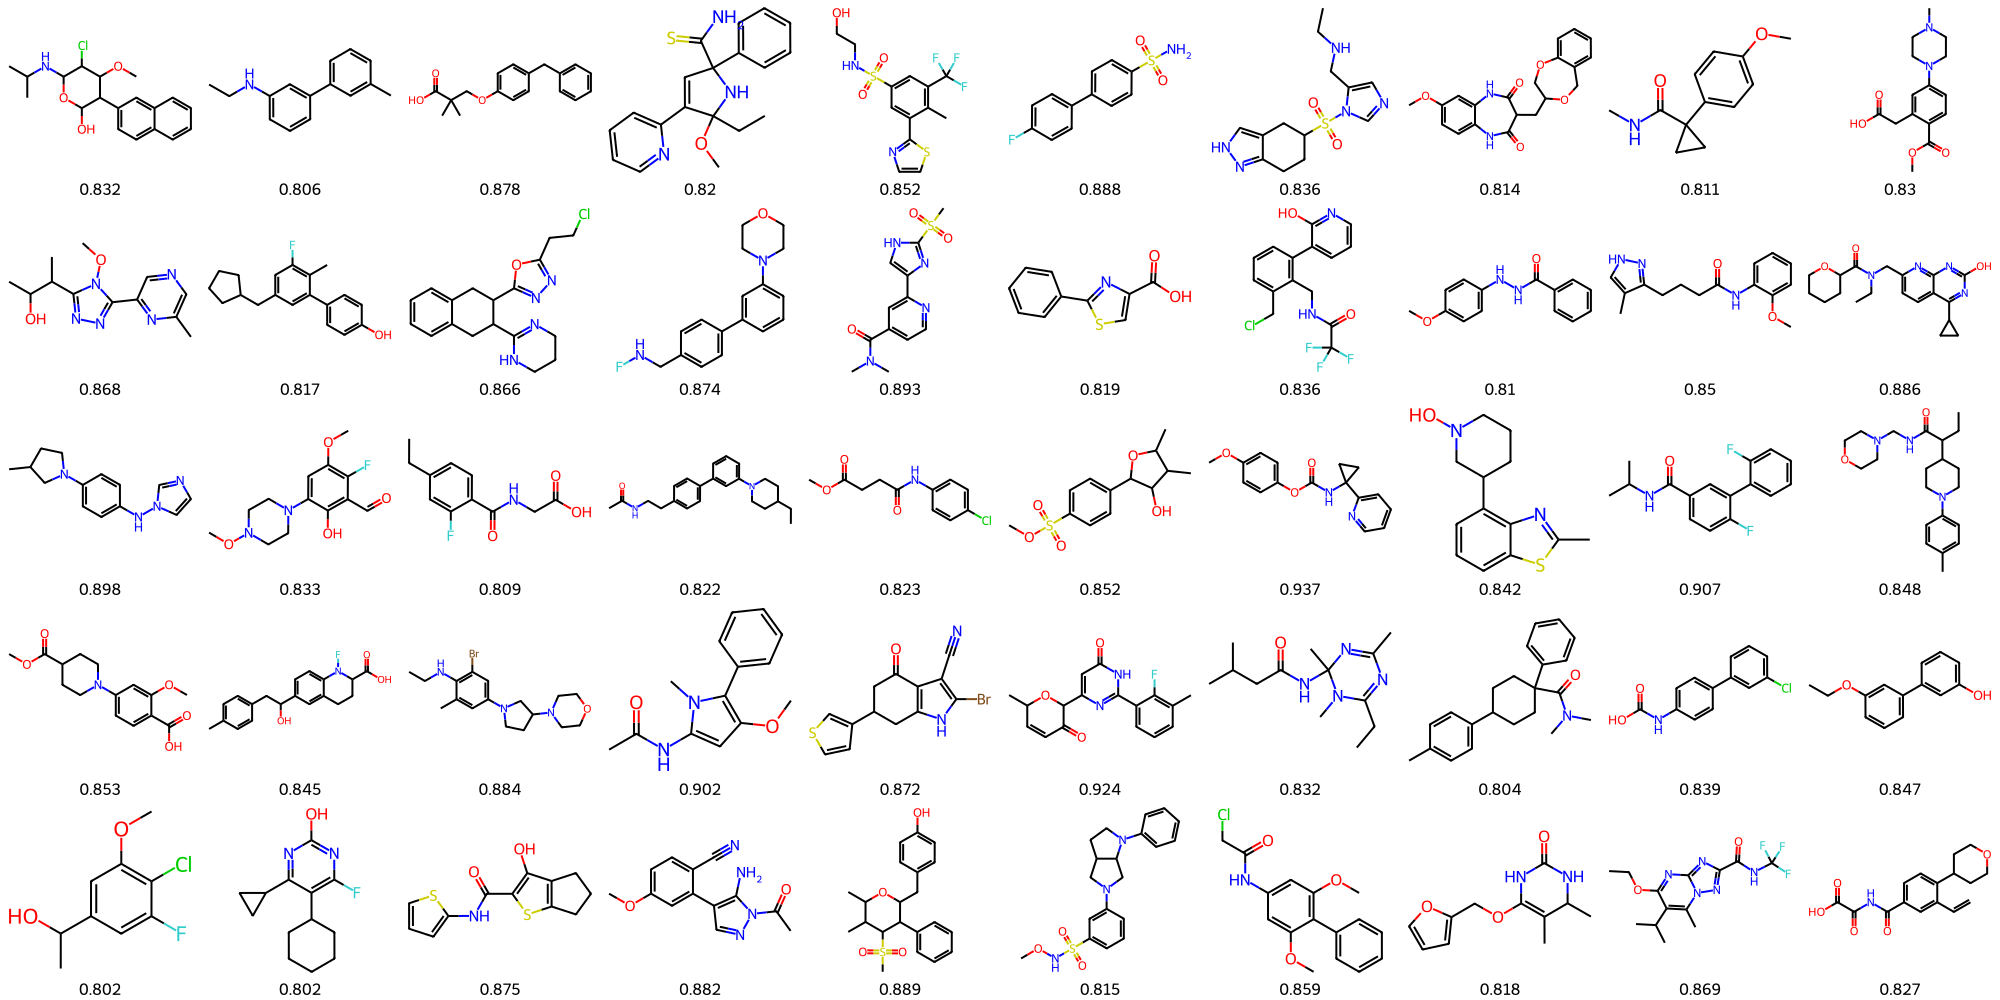

In [54]:
def gen_mol(cconn,nssd,nssdw,cgc):
    """given a reduced graph array and a dict of frags, return a RANDOM molecule
    """
    g=random.choices(cconn,cgc,k=1)[0]
    ds=[len(el) for el in g]
    fr=[random.choices(nssd[d],nssdw[d])[0] for d in ds]
    ringclosures = ["%"+str(i+10) for i in range(sum(ds)//2)]
    for i,rc in enumerate(g):
        for j in rc:
            fr[i]=fr[i].replace("(*)",ringclosures[j],1)
    fr=".".join(fr)
    return fr

t1=time.time()
cmpds=[]
adj_weights={}
for k in nssdw:
    adj_weights[k]=[a**1 for a in nssdw[k]]
for i21 in range(500):
    cmpds.append(gen_mol(cconn,nssd,adj_weights,cgc))
print(time.time()-t1)
mols=[]
for c in cmpds:
    mol=Chem.MolFromSmiles(c)
    if mol==None:
        print("None!! nooooo")
    else:
        mols.append(mol)

from rdkit.Chem import QED
qeds=[]
for m in mols:
    qeds.append(str(round(QED.qed(m),3)))
qmols=[]
qlegend=[]
for i,qe in enumerate(qeds):
    if float(qe)>0.8:
        qmols.append(mols[i])
        qlegend.append(qe)
d = Draw.MolsToGridImage(qmols,molsPerRow=10,legends=qlegend)
print(f"percentage QED over 0.8 is {len(qlegend)/len(qeds)}")
display(d)

In [43]:
len(nssd[2])

353

In [16]:
[cconn,nssd,nssdw,cgc] = pickle.load(gzip.open("model1000.pkl.gz"))

In [2]:
[substructdict,rs,rsbonds] = pickle.load(gzip.open("chembl_data.pkl.gz"))

In [ ]:
# gz pickling the data

In [39]:
extra_data=[substructdict,rs,rsbonds]    
with gzip.open('chembl_data.pkl.gz', "wb") as f:
    pickle.dump(extra_data,f)

In [53]:
model = [cconn,nssd,nssdw,cgc]
with gzip.open('model10000.pkl.gz', "wb") as f:
    pickle.dump(model,f)